In [86]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats
import scipy.optimize
import numpy as np
import math

In [87]:
def create_random_walk(n, v, w):
    """ランダムウォークの真値と観測データを生成
    
    ランダムウォークの真値とノイズ入り観測データを生成

    Args:
        n(int): 生成するデータ数
        v(float): 変動量の分散
        w(float): 観測ノイズの分散
    
    Returns:
        List[flot], List[flot]: 真値,観測データ
    """
    x = np.cumsum(np.random.normal(0.0, math.sqrt(v), n))
    y = x + np.random.normal(0.0, math.sqrt(w), n)
    return x, y

In [88]:
def predict_llm(x, x_var, y, v, w):
    """ローカルレベルモデルでの予測
    
    ローカルレベルモデルで計測値から次のデータを予測

    Args:
        x(float): 現在の予測値
        x_var(float): 現在の予測値の尤度の分散
        y(float): 新しい観測地
        v(float): 変動量の分散
        w(float): 観測ノイズの分散

    Returns:
        flot, float, float: 新しい予測値、新しい予測値の尤度の分散、尤度
    """
    
    # 現在値の予測
    predict_x     = x           # 期待値は前回の値のそのまま
    predict_x_var = x_var + v   # 分散を加算される
    
    # 観測値の予測誤差
    diff = y - predict_x
    
    # 観測値の予測誤差の分散
    predict_var = predict_x_var + w
    
    # 尤度
    likelihood = scipy.stats.norm.pdf(diff, scale=np.sqrt(predict_var))
    
    # カルマンゲインを計算
    kalman_gain = predict_x_var / (predict_x_var + w)
    
    # 計測値と合成
    next_x     = predict_x + kalman_gain * (y - predict_x)
    next_x_var = (1 - kalman_gain) * predict_x_var
    
    # 2変数の最適合成という点ではこう書いても等価のはず
#   next_x     = (w * predict_x +  predict_x_var * y) / (predict_x_var * w)
#   next_x_var = (predict_x_var * w) / (predict_x_var + w)
        
    return next_x, next_x_var, likelihood

In [89]:
# ローカルレベルモデルで計測値から予測を実施
def calc_predict(y, v, w):
    n = len(y)
    x     = np.ndarray(n)
    x_var = np.ndarray(n)
    l     = np.ndarray(n)
    x[0]     = 0
    x_var[0] = 0
    for i in range(1, n):
        x[i], x_var[i], l[i] = predict_llm(x[i-1], x_var[i-1], y[i], v, w)
    return x, x_var, l

In [90]:
# 分散が既知の状態で計算してみる
v = 1.0
w = 4.0
x_true, y = create_data(100, v, w)
x, x_var, l = calc_predict(y, v, w)

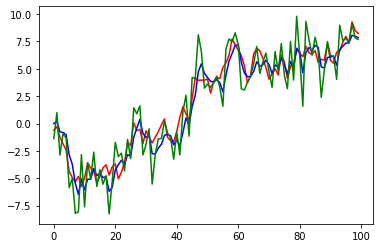

In [91]:
plt.plot(x_true, c='red')
plt.plot(x, c='blue')
plt.plot(y, c='green')

In [21]:
# 分散をデータから予測する
# のを今度やってみよう